# Importing the Necessary Libraries

In [ ]:
import re   #for regex
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  #for various plots
import seaborn as sns

In [ ]:
import nltk
import string
from nltk.corpus import stopwords


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 7.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer

# Loading the datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Twitter Sentiment Analysis, EDA and Visualization/test.csv')
train = pd.read_csv('/content/drive/MyDrive/Twitter Sentiment Analysis, EDA and Visualization/train.csv')
ss = pd.read_csv('/content/drive/MyDrive/Twitter Sentiment Analysis, EDA and Visualization/sample_submission.csv')

# Preprocessing the dataset

In [ ]:
#combine the train and test dataset
df = [train, test]

df = pd.concat(df)

display(df.head(10))

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


In [ ]:
print(df.shape)

(31015, 4)


In [ ]:
df.isnull().sum()

textID              0
text                1
selected_text    3535
sentiment           0
dtype: int64

In [ ]:
#drop the 1 row with null value in text column
df.dropna(inplace=True)

**Dataset Analysis :**

1. textID : A unique identifier
2. text : The actual tweet made by the user
3. selected_text : The stripped down tweet that can be fed to a Machine Learning model to make assumptions.
4. sentiment : The sentiment of the tweet that a Maching learning model tries to predict.


In [ ]:
# Sort the sentiments by ascending order
df = df.sort_values(by='sentiment')

#drop the selected_text column
df = df.drop('selected_text', axis=1)

#The reason to drop the column is to get more words from the text column to verify whether the sentiment predicted is correct or not

In [ ]:
df.head(10)

,textID,text,sentiment
15563,2543065d78,Is there a way I can sleep for the next 8 or 9...,negative
6044,ee267131b1,ok... twitter I almost pass out because of you...,negative
21221,5b4cf5d1c6,watching The Biggest Loser on Hallmark. Never ...,negative
6041,856e0029b7,Greg Pritchard should have got threw to the fi...,negative
21223,5c83af1147,Gourmet pizza = BLEH. Pizza is SUPPOSED to be...,negative
21227,8581262345,There isn`t any right now. They need to make...,negative
10884,a435e058ae,srry can`t go paintballing tonight and there...,negative
16125,3cbcb82071,LOL too bad he`s taken!!!!!!!,negative
21230,7416c5eee3,hypnotyst .... hmmmm... i should beware..,negative
21231,a24c1d14d7,http://twitpic.com/67nxe - Yeah..I`m bored XD ...,negative


# Cleaning the text

In [ ]:
#Make all the characters lower case
df['text'] = df['text'].str.lower()

In [ ]:
#Remove multple spaces
df['text'] = df['text'].map(lambda x: re.sub("\s{2,6}", " ", x))

In [ ]:
df['text']

15563    is there a way i can sleep for the next 8 or 9...
6044     ok... twitter i almost pass out because of you...
21221    watching the biggest loser on hallmark. never ...
6041     greg pritchard should have got threw to the fi...
21223     gourmet pizza = bleh. pizza is supposed to be...
                               ...                        
6253      he needs to go back to his scotty. that is wh...
20996    radio:active never gets old and never will thi...
10999                         is maxin and relaxin... ahhh
21020     just wanted to say that i <3 ur music(both th...
6759      ooohhh well you could always borrow and burn ...
Name: text, Length: 27480, dtype: object

# Exploratory Data Analysis (EDA)

In [ ]:
df.describe()

,textID,text,sentiment
count,27480,27480,27480
unique,27480,27429,3
top,2543065d78,thanks,neutral
freq,1,5,11117


In [ ]:
check = df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
check.style.background_gradient(cmap='Greens')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


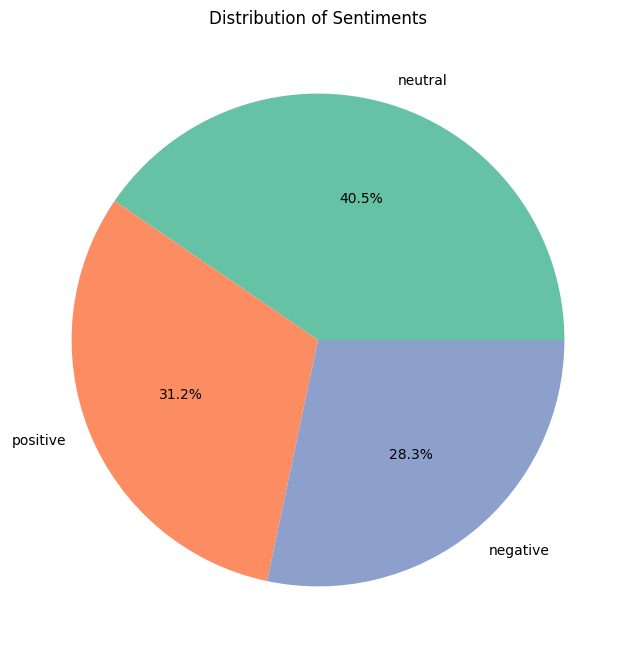

In [ ]:
# Count the occurrences of each sentiment
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, colors=sns.color_palette('Set2'), autopct='%1.1f%%')
plt.title('Distribution of Sentiments')
plt.show()


Now let's go deeper into the sentiments, every sentiment has distinguised emotions.


Such as : anger, fear, anticipation, trust, surprise, sadness, joy, and disgust

In [ ]:
#Delete Url's in the post
df['text'] = df['text'].map(lambda x: re.sub('http[s]?:/\/\[^\s]*', ' ',x))

In [ ]:
df['text']

15563    is there a way i can sleep for the next 8 or 9...
6044     ok... twitter i almost pass out because of you...
21221    watching the biggest loser on hallmark. never ...
6041     greg pritchard should have got threw to the fi...
21223     gourmet pizza = bleh. pizza is supposed to be...
                               ...                        
6253      he needs to go back to his scotty. that is wh...
20996    radio:active never gets old and never will thi...
10999                         is maxin and relaxin... ahhh
21020     just wanted to say that i <3 ur music(both th...
6759      ooohhh well you could always borrow and burn ...
Name: text, Length: 27480, dtype: object

In [ ]:
df_text = df['text']
df_text

15563    is there a way i can sleep for the next 8 or 9...
6044     ok... twitter i almost pass out because of you...
21221    watching the biggest loser on hallmark. never ...
6041     greg pritchard should have got threw to the fi...
21223     gourmet pizza = bleh. pizza is supposed to be...
                               ...                        
6253      he needs to go back to his scotty. that is wh...
20996    radio:active never gets old and never will thi...
10999                         is maxin and relaxin... ahhh
21020     just wanted to say that i <3 ur music(both th...
6759      ooohhh well you could always borrow and burn ...
Name: text, Length: 27480, dtype: object

In [ ]:
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words and word not in punctuation]
    return ' '.join(filtered_words)

df['text'] = df_text.apply(remove_stopwords)

In [ ]:
default_stop_words = set(TfidfVectorizer(stop_words="english").get_stop_words())
all_stop_words = list(default_stop_words.union(stop_words))

In [ ]:
vectorizer_model =  TfidfVectorizer(stop_words= list(stop_words),
                                    ngram_range=(2,3), sublinear_tf=True)
sentence_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
topic_model = BERTopic(vectorizer_model = vectorizer_model)
topics, probs = topic_model.fit_transform(df['text'])

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model = "j-hartmann/emotion-english-distilroberta-base", top_k = 8) #using top_k to get the top 8 sentiment score
sentiment = classifier('df_f')
sentiment

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

[[{'label': 'neutral', 'score': 0.7798877358436584},
  {'label': 'surprise', 'score': 0.07403440773487091},
  {'label': 'sadness', 'score': 0.054175395518541336},
  {'label': 'anger', 'score': 0.04028287157416344},
  {'label': 'joy', 'score': 0.020953591912984848},
  {'label': 'disgust', 'score': 0.019315825775265694},
  {'label': 'fear', 'score': 0.011350187472999096}]]

In [ ]:
topic_model.get_topic_info()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,10901,-1_low low_im crying_low low low_getting ready...,"[low low, im crying, low low low, getting read...",[wonders i`m 1 dat n church sumtime nt knowng ...
1,0,930,0_day happy mothers_mothers day happy_mothers ...,"[day happy mothers, mothers day happy, mothers...","[happy mothers` day moms!, happy mothers day m..."
2,1,926,1_still awake_bed night_sleep night_get sleep,"[still awake, bed night, sleep night, get slee...",[ha think got like two hours sleep last night ...
3,2,491,2_welcome twitter_im twitter_new twitter_saw t...,"[welcome twitter, im twitter, new twitter, saw...","[certain tweets write spot messages person, gr..."
4,3,405,3_new album_lost voice_listening music_listeni...,"[new album, lost voice, listening music, liste...",[saw fiddler topol! girls looooved it! next mo...
...,...,...,...,...,...
320,319,10,319_nxt wari fun_us scorpian_naisee bad see_ni...,"[nxt wari fun, us scorpian, naisee bad see, ni...",[naisee. bad see lens flares arond listening i...
321,320,10,320_luck finals_good luck finals_luck finals e...,"[luck finals, good luck finals, luck finals ev...","[could barely sleep last night, ugh...anyways ..."
322,321,10,321_jerrys loved place_9am ok cause_day open_c...,"[jerrys loved place, 9am ok cause, day open, c...","[ahhhh! cant find anything way much open, haha..."
323,322,10,322_engineer making tracks_believed created mi...,"[engineer making tracks, believed created mill...",[whole time ton things u would believe u would...


In [ ]:
topic_grams = []
num_topics = topic_model.get_topic_info().shape[0]
for k in range(num_topics):
    cur_top = topic_model.get_topic(k)
    if cur_top:
        cur_d = {'topic number': k}
        for j in range(10):
            cur_d[f'topic ngram {j+1}'] = cur_top[j][0]
        topic_grams.append(cur_d)
topics_df = pd.DataFrame(topic_grams)

In [ ]:
topics_df

,topic number,topic ngram 1,topic ngram 2,topic ngram 3,topic ngram 4,topic ngram 5,topic ngram 6,topic ngram 7,topic ngram 8,topic ngram 9,topic ngram 10
0,0,day happy mothers,mothers day happy,mothers day mothers,day moms,mothers day moms,day mothers,moms happy,mom happy,moms day,moms happy mothers
1,1,still awake,bed night,sleep night,get sleep,cant sleep,sleep slept,night everyone,im going bed,time bed,sleep still
2,2,welcome twitter,im twitter,new twitter,saw tweet,twitter lol,twitter account,twitter im,got twitter,twitter love,tweet later
3,3,new album,lost voice,listening music,listening new,love music,im listening,new song,song listening,good song,fav song
4,4,stuck traffic,parking lot,traffic jam,new car,public transport,speeding ticket,car drive,car late,inspection sticker,tha bus
...,...,...,...,...,...,...,...,...,...,...,...
319,319,nxt wari fun,us scorpian,naisee bad see,nite naisee bad,hi hopin,jass warn,nxt wari,warn b4,avin gud,bad see lens
320,320,luck finals,good luck finals,luck finals everyone,second week june,im starting finals,bummer yo im,finals soonso guess,yo im starting,guess ill see,starting finals soonso
321,321,jerrys loved place,9am ok cause,day open,cause one orange,ok cause one,today hmv,hmv opens,opens half,half ourbetter,ourbetter go
322,322,engineer making tracks,believed created million,created million people,howser got,idea captains,log truly,truly enlightening,enlightening pollard,pollard denial,denial truth


In [ ]:
topic_model.get_topic(2)

[('welcome twitter', 0.002884449609169769),
 ('im twitter', 0.0026547569132210846),
 ('new twitter', 0.002579003386770751),
 ('saw tweet', 0.0025069856155680095),
 ('twitter lol', 0.0023235970202756958),
 ('twitter account', 0.0022786288049295067),
 ('twitter im', 0.0021816030966903483),
 ('got twitter', 0.0021513971716379536),
 ('twitter love', 0.0021049904562209306),
 ('tweet later', 0.0020979755897523964)]

In [ ]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli")


config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

In [ ]:
text_labels = ["anticipation", "anger", "fear", "joy", "trust", "surprise","sadness"]


In [ ]:
sample_text = " I don't know if I should be excited or worried right now. I mean, I'm thrilled about the possibilities and opportunities ahead, but at the same time, there's this gnawing sense of uncertainty and fear of the unknown. It's like I'm standing on the edge of a cliff, eager to leap into the adventure, yet hesitant because I can't see what's below."

In [ ]:
classifier(sample_text, text_labels, multi_label = False)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'sequence': " I don't know if I should be excited or worried right now. I mean, I'm thrilled about the possibilities and opportunities ahead, but at the same time, there's this gnawing sense of uncertainty and fear of the unknown. It's like I'm standing on the edge of a cliff, eager to leap into the adventure, yet hesitant because I can't see what's below.",
 'labels': ['fear',
  'anticipation',
  'surprise',
  'joy',
  'sadness',
  'trust',
  'anger'],
 'scores': [0.5346909165382385,
  0.4214157462120056,
  0.03750550001859665,
  0.0020592096261680126,
  0.002021969761699438,
  0.001491756527684629,
  0.0008147756452672184]}

In [ ]:
def predict_sentiment(df, text_column, text_labels):
    if text_column not in df.columns:
        raise ValueError(f"The DataFrame does not contain the column: {text_column}")

    results = []
    for index, row in df.iterrows():
        sequence_to_classify = row[text_column]
        result = classifier(sequence_to_classify, text_labels, multi_label=False)
        results.append({
            text_column: sequence_to_classify,
            'sentiment': result['labels'][0],
            'score': result['scores'][0]
        })

    result_df = pd.DataFrame(results)
    result_df = df.merge(result_df, left_on=text_column, right_on='text', how='outer')
    return result_df


results_df = predict_sentiment(df.head(10), text_column="text", text_labels=text_labels)
print(results_df.head(10))

       textID                                               text sentiment_x  \
0  2543065d78  way sleep next 8 9 days? way wake up, she`ll r...    negative   
1  ee267131b1           ok... twitter almost pass you!! **** :`(    negative   
2  5b4cf5d1c6  watching biggest loser hallmark. never fails m...    negative   
3  856e0029b7  greg pritchard got threw final britains got ta...    negative   
4  5c83af1147  gourmet pizza bleh. pizza supposed greasy filt...    negative   
5  8581262345            isn`t right now. need make more. sorry.    negative   
6  a435e058ae     srry can`t go paintballing tonight good movies    negative   
7  3cbcb82071                          lol bad he`s taken!!!!!!!    negative   
8  7416c5eee3                   hypnotyst .... hmmmm... beware..    negative   
9  a24c1d14d7  http://twitpic.com/67nxe yeah..i`m bored xd pi...    negative   

    sentiment_y     score  
0  anticipation  0.930641  
1  anticipation  0.785657  
2       sadness  0.872735  
3  anti

In [ ]:
output_file_path = '/content/drive/MyDrive/Twitter Sentiment Analysis, EDA and Visualization/results_df.csv'  # Ensure this path matches the directory of your original dataset
results_df.to_csv(output_file_path, index=False)
